# CSE-6363 homework-2

Team Members:
    1. Nikhil Reddy Duggireddy  -1001968033
    2. Laya Kalali              -1002128876
    3. Sasikala Paturu          -1002083123
    4. Lokeshwar Kodipunjula    -1002175121

# Step 1: Fully Connected Neural Network from Scratch

## 1.1. Loading the CIFAR10 Dataset

In [10]:
import torch
import torchvision
import numpy as np
from torch.utils.data import random_split, DataLoader

# Transform to normalize data to range [-1, 1]
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean 0.5 and std 0.5
])

# Download training and test data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split into training (90%) and validation (10%)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
train_data, val_data = random_split(trainset, [train_size, val_size])


# Convert datasets into DataLoader for batching
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Test loader for predictions later
test_loader = DataLoader(testset, batch_size=1, shuffle=False)

# CIFAR-10 has 10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to flatten images and convert to numpy
def preprocess_data(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy().flatten().reshape(-1, 1))  # Flatten image to 3072 and reshape to (3072, 1)
        one_hot_label = np.zeros((10, 1))  # One-hot encode label
        one_hot_label[label] = 1
        labels.append(one_hot_label)
    return np.hstack(images), np.hstack(labels)

# Preprocess training and validation data
X_train, y_train = preprocess_data(train_data)
X_val, y_val = preprocess_data(val_data)


Files already downloaded and verified
Files already downloaded and verified


## 1.2. Implementing the Fully Connected Neural Network

In [11]:
import numpy as np

class NeuralNetwork:
    def __init__(self, layer_dimensions):
        # layer_dimensions = [input_size, hidden1_size, hidden2_size, ..., output_size]
        self.parameters = {}
        self.L = len(layer_dimensions) - 1  # Number of layers (excluding input layer)

        # Initialize weights and biases
        for l in range(1, self.L + 1):
            self.parameters['W' + str(l)] = np.random.randn(layer_dimensions[l], layer_dimensions[l-1]) * 0.01
            self.parameters['b' + str(l)] = np.zeros((layer_dimensions[l], 1))

    def affineForward(self, A, W, b):
        Z = np.dot(W, A) + b
        return Z

    def activationForward(self, A):
        return np.maximum(0, A)  # ReLU activation

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)

    def forwardPropagation(self, X):
        caches = {}
        A = X
        caches['A0'] = A

        # Forward pass through layers
        for l in range(1, self.L + 1):
            W = self.parameters['W' + str(l)]
            b = self.parameters['b' + str(l)]
            Z = self.affineForward(A, W, b)
            A = self.activationForward(Z) if l != self.L else self.softmax(Z)
            caches['A' + str(l)] = A
            caches['Z' + str(l)] = Z

        return A, caches

    def costFunction(self, AL, y):
        m = y.shape[0]
        cost = -np.sum(y * np.log(AL)) / m
        # m = y.shape[1]
        # cost = -np.sum(y * np.log(AL + 1e-8)) / m
        return cost

    def affineBackward(self, dZ, A_prev, W):
        m = A_prev.shape[1]
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = np.dot(W.T, dZ)
        return dA_prev, dW, db

    def activationBackward(self, dA, Z):
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0  # Derivative of ReLU
        return dZ

    def backPropagation(self, AL, Y, caches):
        gradients = {}
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)  # Reshape Y to be the same shape as AL

        # Initial gradient for softmax layer
        dAL = AL - Y

        for l in reversed(range(1, self.L + 1)):
            A_prev = caches['A' + str(l - 1)]
            Z = caches['Z' + str(l)]
            W = self.parameters['W' + str(l)]

            if l == self.L:
                dZ = dAL
            else:
                dZ = self.activationBackward(dAL, Z)

            dAL, dW, db = self.affineBackward(dZ, A_prev, W)

            # Store gradients
            gradients['dW' + str(l)] = dW
            gradients['db' + str(l)] = db

        return gradients

    def updateParameters(self, gradients, alpha):
        # Update the weights using gradient descent
        for l in range(1, self.L + 1):
            self.parameters['W' + str(l)] -= alpha * gradients['dW' + str(l)]
            self.parameters['b' + str(l)] -= alpha * gradients['db' + str(l)]

    def train(self, X_train, y_train, X_val, y_val, iters, alpha, batch_size):
        m = X_train.shape[1]  # Number of examples

        for i in range(iters):
            indices = np.random.permutation(m)
            X_train_shuffled = X_train[:, indices]
            y_train_shuffled = y_train[:, indices]

            epoch_loss = 0  # Track loss for the epoch
            for j in range(0, m, batch_size):
                X_batch = X_train_shuffled[:, j:j+batch_size]
                y_batch = y_train_shuffled[:, j:j+batch_size]

                # Forward propagation
                AL, caches = self.forwardPropagation(X_batch)

                # Compute cost
                cost = self.costFunction(AL, y_batch)

                # Backward propagation
                gradients = self.backPropagation(AL, y_batch, caches)

                # Update parameters
                self.updateParameters(gradients, alpha)

            # Average loss for the epoch
            avg_epoch_loss = epoch_loss / (m / batch_size)

            # Compute training accuracy
            train_acc = self.evaluate(X_train, y_train)
            # Compute validation accuracy
            val_acc = self.evaluate(X_val, y_val)

            # Print metrics
            if i % 10 == 0:  # Print every 10 iterations
              print(f"Iteration {i}, Cost: {avg_epoch_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")

    def evaluate(self, X, y):
        AL, _ = self.forwardPropagation(X)
        predictions = np.argmax(AL, axis=0)
        labels = np.argmax(y, axis=0)
        accuracy = np.mean(predictions == labels) * 100  # Calculate accuracy
        return accuracy

    def predict(self, X_new):
        AL, _ = self.forwardPropagation(X_new)
        return np.argmax(AL, axis=0)

# Network Architecture: input layer (3072), one hidden layer (128 neurons), output layer (10 neurons)
layer_dimensions = [3072, 128, 10]

# Create an instance of NeuralNetwork
network = NeuralNetwork(layer_dimensions)

# Hyperparameters
iterations = 50  # Number of iterations
learning_rate = 0.01  # Learning rate
batch_size = 64  # Batch size

# Train the network
network.train(X_train, y_train, X_val, y_val, iters=iterations, alpha=learning_rate, batch_size=batch_size)


Iteration 0, Cost: 0.0000, Train Accuracy: 33.26%, Validation Accuracy: 32.98%
Iteration 10, Cost: 0.0000, Train Accuracy: 52.59%, Validation Accuracy: 48.80%
Iteration 20, Cost: 0.0000, Train Accuracy: 58.83%, Validation Accuracy: 51.36%
Iteration 30, Cost: 0.0000, Train Accuracy: 63.54%, Validation Accuracy: 52.06%
Iteration 40, Cost: 0.0000, Train Accuracy: 66.15%, Validation Accuracy: 51.14%


## 1.3. Displaying Predictions

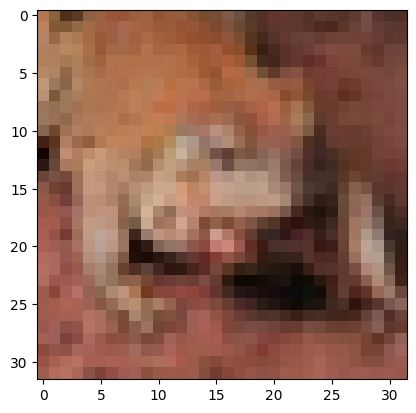

Predicted label: frog


In [12]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display an image from testset
imshow(testset[5][0])

# Predict label for the image
image = testset[5][0].numpy().flatten().reshape(-1, 1)
label = network.predict(image)
print(f"Predicted label: {classes[label[0]]}")


# Step 2: Convolutional Neural Network (CNN) using PyTorch

## 2.1. Loading the CIFAR10 Dataset

Since the CIFAR10 dataset was previously loaded, you can reuse the same code. The trainloader, valloader, and testloader are now prepared for CNN training.



## 2.2. Implementing the CNN using PyTorch

We will construct a CNN that includes at least two convolutional layers, followed by pooling and normalization layers, ReLU activation functions, a fully connected layer, and a softmax output layer. Additionally, we will implement dropout and utilize gradient descent as the optimizer.

In [13]:
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # 32 filters, kernel size 3
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # 64 filters
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization

        # Fully connected layer
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # Input size based on previous layers
        self.fc2 = nn.Linear(512, 10)  # Output layer (10 classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> Pooling
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> Pooling
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))  # Fully connected layer with ReLU
        x = self.fc2(x)  # Output layer
        return x


## 2.3. Training and Evaluating the Model

We will now train the network for a specified number of epochs, keeping track of both the training and validation accuracy throughout the training process.

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            running_loss += loss.item()  # Track running loss
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels
            total += labels.size(0)  # Update total count
            correct += (predicted == labels).sum().item()  # Update correct predictions

        # Calculate training accuracy
        train_accuracy = 100 * correct / total
        val_accuracy = evaluate_model(model, val_loader, criterion)

        # Average loss for the epoch
        avg_loss = running_loss / len(train_loader)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

def evaluate_model(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation needed
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation accuracy
    val_accuracy = 100 * correct / total
    return val_accuracy


## 2.4. Initialize the model, criterion, and optimizer

In [15]:
# Initialize the model, criterion, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD optimizer with momentum

# Train the model
num_epochs = 10  # Number of epochs for training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch [1/10], Loss: 1.2888, Train Accuracy: 53.38%, Validation Accuracy: 60.26%
Epoch [2/10], Loss: 0.9151, Train Accuracy: 67.52%, Validation Accuracy: 67.46%
Epoch [3/10], Loss: 0.7359, Train Accuracy: 74.17%, Validation Accuracy: 68.68%
Epoch [4/10], Loss: 0.5945, Train Accuracy: 79.26%, Validation Accuracy: 71.78%
Epoch [5/10], Loss: 0.4705, Train Accuracy: 83.51%, Validation Accuracy: 72.50%
Epoch [6/10], Loss: 0.3580, Train Accuracy: 87.70%, Validation Accuracy: 73.88%
Epoch [7/10], Loss: 0.2597, Train Accuracy: 90.86%, Validation Accuracy: 74.04%
Epoch [8/10], Loss: 0.1742, Train Accuracy: 94.18%, Validation Accuracy: 73.90%
Epoch [9/10], Loss: 0.1209, Train Accuracy: 96.01%, Validation Accuracy: 74.32%
Epoch [10/10], Loss: 0.0745, Train Accuracy: 97.68%, Validation Accuracy: 74.76%


## 2.5. Displaying Predictions

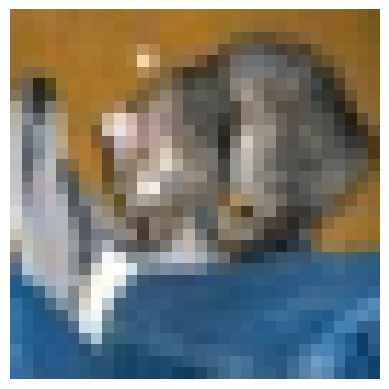

Predicted label: cat, True label: cat


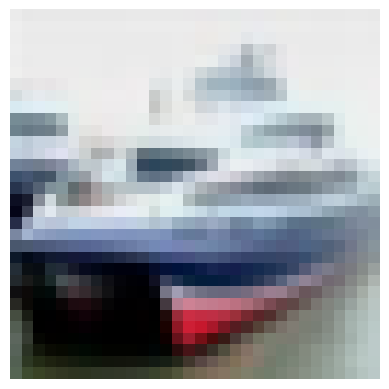

Predicted label: ship, True label: ship


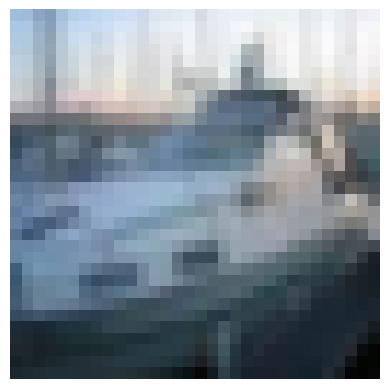

Predicted label: ship, True label: ship


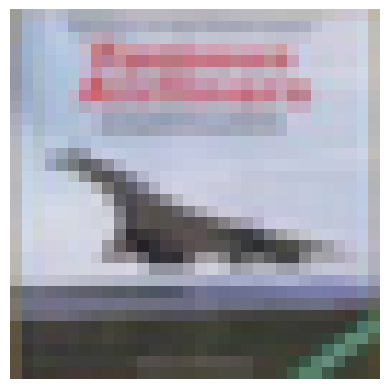

Predicted label: airplane, True label: airplane


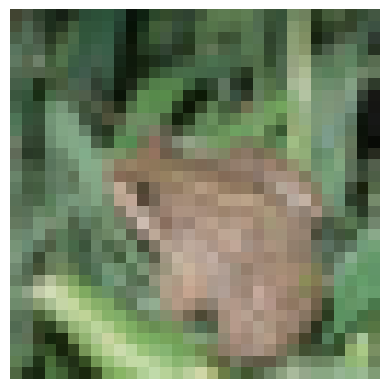

Predicted label: frog, True label: frog


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Change shape for displaying
    plt.axis('off')
    plt.show()

# Function to predict and display results
def predict_and_display(model, testset, num_images=5):
  model.eval()
  with torch.no_grad():
        images, labels = zip(*[testset[i] for i in range(num_images)])  # Get first 'num_images' from testset
        images = torch.stack(images)  # Create a batch of images
        outputs = model(images)  # Get model outputs
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes

        learning_rates = [0.001, 0.01, 0.0001]

        # Display images and their predictions
        for i in range(num_images):
            imshow(images[i])
            print(f'Predicted label: {classes[predicted[i]]}, True label: {classes[labels[i]]}')

# Call the function to predict and display results
predict_and_display(model, testset, num_images=5)

# Step 3: Different Methods to Improve Performance

**3.1. Change the Optimizer:** Try using the Adam optimizer instead of SGD for potentially faster convergence and better accuracy.

**3.2. Different Learning Rates:** The learning rate is a key hyperparameter when training neural networks. A learning rate that is too high can cause the training to diverge, while one that is too low may lead to slow convergence. We will run experiments with the following three learning rates:




*   0.001 (default)
*   0.01 (higher rate)

*   0.0001 (lower rate)










In [18]:
# Function to run experiments with different learning rates and Changed Optimizer
def run_experiments(learning_rates):
    for lr in learning_rates:
        print(f"\nTraining model with learning rate: {lr}")
        model = CNN()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)  # Using Adam optimizer

        num_epochs = 10
        train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
        return model

# Define learning rates to experiment with
learning_rates = [0.001, 0.01, 0.0001]
run_experiments(learning_rates)


Training model with learning rate: 0.001
Epoch [1/10], Loss: 1.3355, Train Accuracy: 51.95%, Validation Accuracy: 59.86%
Epoch [2/10], Loss: 0.9339, Train Accuracy: 67.00%, Validation Accuracy: 67.98%
Epoch [3/10], Loss: 0.7921, Train Accuracy: 71.89%, Validation Accuracy: 70.06%
Epoch [4/10], Loss: 0.6945, Train Accuracy: 75.50%, Validation Accuracy: 72.30%
Epoch [5/10], Loss: 0.6068, Train Accuracy: 78.75%, Validation Accuracy: 69.86%
Epoch [6/10], Loss: 0.5343, Train Accuracy: 81.12%, Validation Accuracy: 73.18%
Epoch [7/10], Loss: 0.4561, Train Accuracy: 83.93%, Validation Accuracy: 74.02%
Epoch [8/10], Loss: 0.3940, Train Accuracy: 85.95%, Validation Accuracy: 74.76%
Epoch [9/10], Loss: 0.3271, Train Accuracy: 88.47%, Validation Accuracy: 74.22%
Epoch [10/10], Loss: 0.2751, Train Accuracy: 90.34%, Validation Accuracy: 74.24%


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

**3.3. Data Augmentation Techniques:** o enhance the model's generalization, we'll apply additional data augmentation methods. Some of the specific augmentations we could implement include:



*   Random Vertical Flip: Flipping the images vertically.
*   Random Erasing: Randomly selecting a rectangular region in an image and erasing the pixels in that area.
*  Rotation: Randomly rotating images within a specified range of degrees.






In [19]:

import torchvision
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### 3.4. Displaying Predictions


Training model with learning rate: 0.001
Epoch [1/10], Loss: 1.2892, Train Accuracy: 53.74%, Validation Accuracy: 62.96%
Epoch [2/10], Loss: 0.9227, Train Accuracy: 67.50%, Validation Accuracy: 65.58%
Epoch [3/10], Loss: 0.7761, Train Accuracy: 72.72%, Validation Accuracy: 70.88%
Epoch [4/10], Loss: 0.6617, Train Accuracy: 76.81%, Validation Accuracy: 70.32%
Epoch [5/10], Loss: 0.5702, Train Accuracy: 79.79%, Validation Accuracy: 72.12%
Epoch [6/10], Loss: 0.4878, Train Accuracy: 82.88%, Validation Accuracy: 71.12%
Epoch [7/10], Loss: 0.4115, Train Accuracy: 85.58%, Validation Accuracy: 73.12%
Epoch [8/10], Loss: 0.3307, Train Accuracy: 88.37%, Validation Accuracy: 74.16%
Epoch [9/10], Loss: 0.2710, Train Accuracy: 90.41%, Validation Accuracy: 73.14%
Epoch [10/10], Loss: 0.2154, Train Accuracy: 92.40%, Validation Accuracy: 73.76%


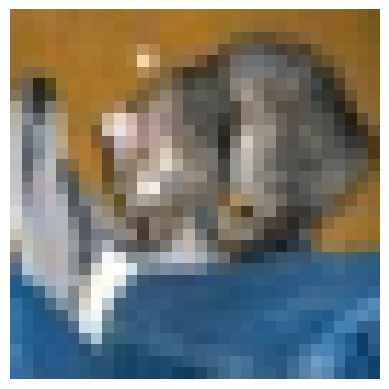

Predicted label: cat, True label: cat


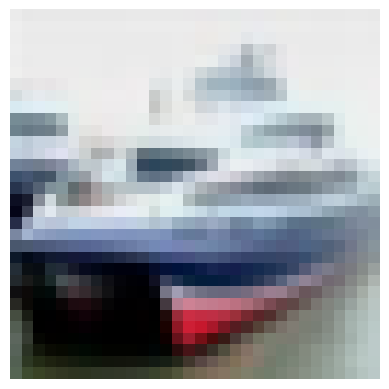

Predicted label: ship, True label: ship


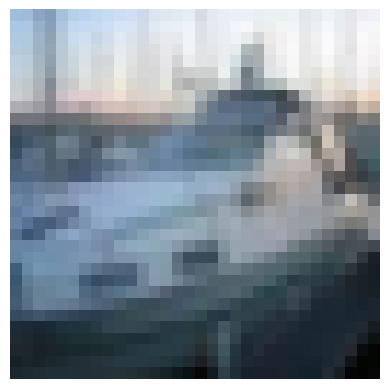

Predicted label: ship, True label: ship


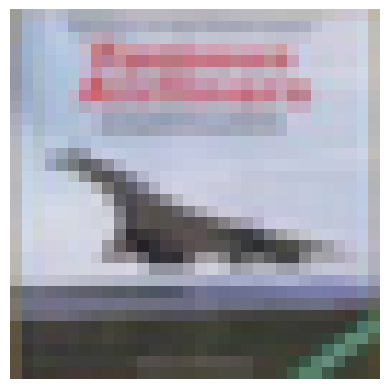

Predicted label: airplane, True label: airplane


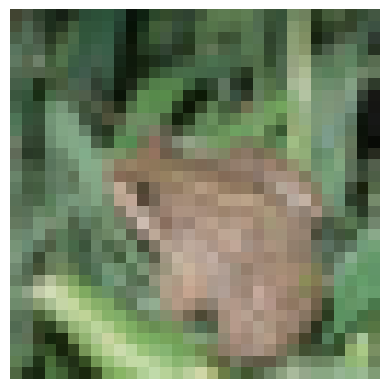

Predicted label: frog, True label: frog


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Change shape for displaying
    plt.axis('off')
    plt.show()

# Function to predict and display results
def predict_and_display(model, testset, num_images=5):
  model.eval()
  with torch.no_grad():
        images, labels = zip(*[testset[i] for i in range(num_images)])  # Get first 'num_images' from testset
        images = torch.stack(images)  # Create a batch of images
        outputs = model(images)  # Get model outputs
        _, predicted = torch.max(outputs.data, 1)  # Get predicted classes



        # Display images and their predictions
        for i in range(num_images):
            imshow(images[i])
            print(f'Predicted label: {classes[predicted[i]]}, True label: {classes[labels[i]]}')

learning_rates = [0.001, 0.01, 0.0001]

model = run_experiments(learning_rates)

# Call the function to predict and display results
predict_and_display(model, testset, num_images=5)